# Project: Predicting house sale prices  
**Data:** housing data for the city of Ames, Iowa, USA, 2006 to 2010  
**Data description:** https://s3.amazonaws.com/dq-content/307/data_description.txt  
**Source:** https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627  
**Source pdf:** https://www.tandfonline.com/doi/pdf/10.1080/10691898.2011.11889627?needAccess=true



**Inspirations and research:**
* https://www.kaggle.com/code/solegalli/feature-engineering-for-house-price-modelling
* https://nycdatascience.com/blog/student-works/house-price-prediction-with-creative-feature-engineering-and-advanced-regression-techniques/
* https://rpubs.com/IsaacGabr/795734
* https://www.kaggle.com/code/modassirafzal/housing-top-3/notebook





PDF excerpts:  
    "This paper presents a data set describing the sale of individual residential property in Ames, Iowa
from 2006 to 2010. The data set contains 2930 observations and a large number of explanatory
variables (23 nominal, 23 ordinal, 14 discrete, and 20 continuous) involved in assessing home
values. I will discuss my previous use of the Boston Housing Data Set and I will suggest
methods for incorporating this new data set as a final project in an undergraduate regression
course."

here are
five observations that an instructor may wish to remove from the data set before giving
it to students (a plot of SALE PRICE versus GR LIV AREA will quickly indicate these
points). Three of them are true outliers (Partial Sales that likely don’t represent actual
market values) and two of them are simply unusual sales (very large houses priced
relatively appropriately). I would recommend removing any houses with more than
4000 square feet from the data set (which eliminates these five unusual observations)
before assigning it to students.


specific recommendations:

Eliminate all sales except for the “normal” from the SALES CONDITION variable.
Unless an instructor specifically wants to create an activity that investigates the
difference between the various types of sales (foreclosures, new homes, family sales, etc.)
the different conditions will simply serve to complicate the results and confuse the
students.  

Remove all homes with a living area (GR LIVE AREA) above 1500 square feet. The
purpose to the second step is to alleviate problems with non-homogeneous variance. As
might be expected there is increasing variation with increasing price within the Ames
housing market. This problem can be remedied by taking a transformation (square root)
of the sales price but those wishing to keep the response in dollars can simply use the
smaller homes as they tend to show more homogeneous variation.  

Select desired observations.
Although the data set could be reduced further using other variables (such as using only
one story homes or eliminating homes without a basement), I would recommend drawing
a simple random (or systematic) sample from the remaining “normal” sales to create the
final data set.  

## Importing packages & data

In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from itertools import combinations # check if needed later
from datetime import date #check if needed later
import math
%matplotlib inline

# Setting pandas display options
pd.options.display.max_columns = 200
pd.options.display.max_rows = 100

In [2]:
# Importing source dataset
ames_data = pd.read_csv('C:\\Users\\tgusc\\Documents\\GitHub\\Python\\GP23_PredictingHouseSalePrices\\AmesHousing.tsv', delimiter="\t")

In [3]:
#parameters
seed = 123
target = 'SalePrice'
ID_vars = ['Order', 'PID']

## Dataset inspection

In [4]:
# find categorical variables
categorical = [var for var in ames_data.columns if ames_data[var].dtype=='O']
print('There are {} categorical variables'.format(len(categorical)))

There are 43 categorical variables


In [5]:
# find numerical variables
numerical = [var for var in ames_data.columns if ames_data[var].dtype!='O']
print('There are {} numerical variables'.format(len(numerical)))

There are 39 numerical variables


In [6]:
discrete = []
for var in numerical:
    if len(ames_data[var].unique())<20:
        print(var, ' values: ', ames_data[var].unique())
        discrete.append(var)
        
print('There are {} discrete variables'.format(len(discrete)))

MS SubClass  values:  [ 20  60 120  50  85 160  80  30  90 190  45  70  75  40 180 150]
Overall Qual  values:  [ 6  5  7  8  9  4  3  2 10  1]
Overall Cond  values:  [5 6 7 2 8 4 9 3 1]
Bsmt Full Bath  values:  [ 1.  0.  2.  3. nan]
Bsmt Half Bath  values:  [ 0.  1. nan  2.]
Full Bath  values:  [1 2 3 0 4]
Half Bath  values:  [0 1 2]
Bedroom AbvGr  values:  [3 2 1 4 6 5 0 8]
Kitchen AbvGr  values:  [1 2 3 0]
TotRms AbvGrd  values:  [ 7  5  6  8  4 12 10 11  9  3 13  2 15 14]
Fireplaces  values:  [2 0 1 3 4]
Garage Cars  values:  [ 2.  1.  3.  0.  4.  5. nan]
Pool Area  values:  [  0 144 480 576 555 368 444 228 561 519 648 800 512 738]
Mo Sold  values:  [ 5  6  4  3  1  2  7 10  8 11  9 12]
Yr Sold  values:  [2010 2009 2008 2007 2006]
There are 15 discrete variables


In [7]:
# first we make a list of continuous variables (from the numerical ones)
continuous = [var for var in numerical if var not in discrete and var not in ['PID', 'Order',target]]
continuous

['Lot Frontage',
 'Lot Area',
 'Year Built',
 'Year Remod/Add',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 '1st Flr SF',
 '2nd Flr SF',
 'Low Qual Fin SF',
 'Gr Liv Area',
 'Garage Yr Blt',
 'Garage Area',
 'Wood Deck SF',
 'Open Porch SF',
 'Enclosed Porch',
 '3Ssn Porch',
 'Screen Porch',
 'Misc Val']

## Preliminary data cleaning

In [8]:
# Converting object types to numbers and strings
ames_data = ames_data.convert_dtypes()

for column in ames_data.select_dtypes(include=['int']).columns:
    ames_data[column] = ames_data[column].astype(float)

ames_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   float64
 1   PID              2930 non-null   float64
 2   MS SubClass      2930 non-null   float64
 3   MS Zoning        2930 non-null   string 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   float64
 6   Street           2930 non-null   string 
 7   Alley            198 non-null    string 
 8   Lot Shape        2930 non-null   string 
 9   Land Contour     2930 non-null   string 
 10  Utilities        2930 non-null   string 
 11  Lot Config       2930 non-null   string 
 12  Land Slope       2930 non-null   string 
 13  Neighborhood     2930 non-null   string 
 14  Condition 1      2930 non-null   string 
 15  Condition 2      2930 non-null   string 
 16  Bldg Type        2930 non-null   string 
 17  House Style   

In [9]:
ames_data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1.0,526301100.0,20.0,RL,141.0,31770.0,Pave,<NA>,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6.0,5.0,1960.0,1960.0,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656.0,0.0,0.0,1656.0,1.0,0.0,1.0,0.0,3.0,1.0,TA,7.0,Typ,2.0,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210.0,62.0,0.0,0.0,0.0,0.0,<NA>,<NA>,<NA>,0.0,5.0,2010.0,WD,Normal,215000.0
1,2.0,526350040.0,20.0,RH,80.0,11622.0,Pave,<NA>,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5.0,6.0,1961.0,1961.0,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896.0,0.0,0.0,896.0,0.0,0.0,1.0,0.0,2.0,1.0,TA,5.0,Typ,0.0,<NA>,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140.0,0.0,0.0,0.0,120.0,0.0,<NA>,MnPrv,<NA>,0.0,6.0,2010.0,WD,Normal,105000.0
2,3.0,526351010.0,20.0,RL,81.0,14267.0,Pave,<NA>,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6.0,6.0,1958.0,1958.0,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329.0,0.0,0.0,1329.0,0.0,0.0,1.0,1.0,3.0,1.0,Gd,6.0,Typ,0.0,<NA>,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393.0,36.0,0.0,0.0,0.0,0.0,<NA>,<NA>,Gar2,12500.0,6.0,2010.0,WD,Normal,172000.0
3,4.0,526353030.0,20.0,RL,93.0,11160.0,Pave,<NA>,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7.0,5.0,1968.0,1968.0,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110.0,0.0,0.0,2110.0,1.0,0.0,2.0,1.0,3.0,1.0,Ex,8.0,Typ,2.0,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0.0,0.0,0.0,0.0,0.0,0.0,<NA>,<NA>,<NA>,0.0,4.0,2010.0,WD,Normal,244000.0
4,5.0,527105010.0,60.0,RL,74.0,13830.0,Pave,<NA>,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5.0,5.0,1997.0,1998.0,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928.0,701.0,0.0,1629.0,0.0,0.0,2.0,1.0,3.0,1.0,TA,6.0,Typ,1.0,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212.0,34.0,0.0,0.0,0.0,0.0,<NA>,MnPrv,<NA>,0.0,3.0,2010.0,WD,Normal,189900.0


## Missing values handling
Usually this would be done on train & valid dataset only, excluding test/holdout data in order to prevent information leakage. However because of using mode value for missing data I am relaxing this requirement under assumption that train/valid and test data variable values distribution is similar.

In [10]:
def transform_features(data_in, cutoff_missing = 0.25, cutoff_fill = 0.05, fill_method = 'mode'):
    """
    Transform features based on their characteristics.
    
    Parameters
    ----------
    data_in : str
        DataFrame to analyze.
    cutoff_missing : float64, default = 0.25
        Percentage of missing values used as cutoff point for dropping variable. If missings > cutoff_missing then
        drop variable from DataFrame.
    cutoff_fill : float64, default = 0.05
        Percentage of missing values used as cutoff point for filling missing variables with fill_method. If 
        missings < cutoff_fill then replace missing values with fill_method
    fill_method : str, default = 'mode'
        Filling method for missing values, when variable meets cutoff_fill criteria. Can choose from average, median, mode.    
    seed : int
        Random number seed for results reproductibility.
    train_pct : float64, default 0.8
        Percentage of DS dataset to be used as train. 
        
    Returns
    -------
    data_out : DataFrame
        DataFrame with transformed features.
    """
    data_out = pd.DataFrame()
    missing_info = data_in.isna().sum()/len(data_in)
    dropped_cols = []
    for col in data_in.columns:
        p_miss = missing_info[missing_info.index == col][0]
        if p_miss > cutoff_missing:
            print(col + ' - dropped because of missing values exceeding ' + str(cutoff_missing) + '%.' + ' Missing values = '
                 + str(round(p_miss*100,2)) + '%.')
            dropped_cols.append(col)
    for col_n in data_in.select_dtypes('number'):
        p_miss = missing_info[missing_info.index == col_n][0]
        if ((p_miss <= cutoff_fill) & (p_miss > 0)):
            if fill_method == 'mode':
                fill=data_in[col_n].mode()[0]
            elif fill_method == 'mean':
                fill=np.mean(data_in[col_n])
            elif fill_method == 'median':
                fill=np.median(data_in[col_n])
            else:
                print(fill_method + ' is not known. Column will not be transformed')
                continue
            data_out[col_n] = data_in[col_n].fillna(value = fill)
            print(col_n + ' - ' + str(round(p_miss*100,4)) + '% of missing values. They are replaced with ' + fill_method + ' value - ' + str(fill))
        else :
            data_out[col_n] = data_in[col_n]
            print(col_n + ' - ' + str(round(p_miss*100,4)) + '% of missing values. Variable copied.')
    for col_c in data_in.select_dtypes(exclude='number'):
        if col_c not in dropped_cols:
            data_out[col_c] = data_in[col_c].astype('category')
            print(col_c + ' - ' + str(round(p_miss*100,4)) + '% of missing values. Variable copied as category.')
    return data_out

In [11]:
ames_data_transformed = transform_features(data_in = ames_data)

Alley - dropped because of missing values exceeding 0.25%. Missing values = 93.24%.
Fireplace Qu - dropped because of missing values exceeding 0.25%. Missing values = 48.53%.
Pool QC - dropped because of missing values exceeding 0.25%. Missing values = 99.56%.
Fence - dropped because of missing values exceeding 0.25%. Missing values = 80.48%.
Misc Feature - dropped because of missing values exceeding 0.25%. Missing values = 96.38%.
Order - 0.0% of missing values. Variable copied.
PID - 0.0% of missing values. Variable copied.
MS SubClass - 0.0% of missing values. Variable copied.
Lot Frontage - 16.7235% of missing values. Variable copied.
Lot Area - 0.0% of missing values. Variable copied.
Overall Qual - 0.0% of missing values. Variable copied.
Overall Cond - 0.0% of missing values. Variable copied.
Year Built - 0.0% of missing values. Variable copied.
Year Remod/Add - 0.0% of missing values. Variable copied.
Mas Vnr Area - 0.785% of missing values. They are replaced with mode value - 

In [12]:
ames_data_transformed

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating,Heating QC,Central Air,Electrical,Kitchen Qual,Functional,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Sale Type,Sale Condition
0,1.0,526301100.0,20.0,141.0,31770.0,6.0,5.0,1960.0,1960.0,112.0,639.0,0.0,441.0,1080.0,1656.0,0.0,0.0,1656.0,1.0,0.0,1.0,0.0,3.0,1.0,7.0,2.0,1960.0,2.0,528.0,210.0,62.0,0.0,0.0,0.0,0.0,0.0,5.0,2010.0,215000.0,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,BrkFace,Plywood,Stone,TA,TA,CBlock,TA,Gd,Gd,BLQ,Unf,GasA,Fa,Y,SBrkr,TA,Typ,Attchd,Fin,TA,TA,P,WD,Normal
1,2.0,526350040.0,20.0,80.0,11622.0,5.0,6.0,1961.0,1961.0,0.0,468.0,144.0,270.0,882.0,896.0,0.0,0.0,896.0,0.0,0.0,1.0,0.0,2.0,1.0,5.0,0.0,1961.0,1.0,730.0,140.0,0.0,0.0,0.0,120.0,0.0,0.0,6.0,2010.0,105000.0,RH,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,CBlock,TA,TA,No,Rec,LwQ,GasA,TA,Y,SBrkr,TA,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
2,3.0,526351010.0,20.0,81.0,14267.0,6.0,6.0,1958.0,1958.0,108.0,923.0,0.0,406.0,1329.0,1329.0,0.0,0.0,1329.0,0.0,0.0,1.0,1.0,3.0,1.0,6.0,0.0,1958.0,1.0,312.0,393.0,36.0,0.0,0.0,0.0,0.0,12500.0,6.0,2010.0,172000.0,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,TA,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,TA,Y,SBrkr,Gd,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
3,4.0,526353030.0,20.0,93.0,11160.0,7.0,5.0,1968.0,1968.0,0.0,1065.0,0.0,1045.0,2110.0,2110.0,0.0,0.0,2110.0,1.0,0.0,2.0,1.0,3.0,1.0,8.0,2.0,1968.0,2.0,522.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2010.0,244000.0,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,BrkFace,BrkFace,None,Gd,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,Ex,Typ,Attchd,Fin,TA,TA,Y,WD,Normal
4,5.0,527105010.0,60.0,74.0,13830.0,5.0,5.0,1997.0,1998.0,0.0,791.0,0.0,137.0,928.0,928.0,701.0,0.0,1629.0,0.0,0.0,2.0,1.0,3.0,1.0,6.0,1.0,1997.0,2.0,482.0,212.0,34.0,0.0,0.0,0.0,0.0,0.0,3.0,2010.0,189900.0,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Gd,Y,SBrkr,TA,Typ,Attchd,Fin,TA,TA,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926.0,923275080.0,80.0,37.0,7937.0,6.0,6.0,1984.0,1984.0,0.0,819.0,0.0,184.0,1003.0,1003.0,0.0,0.0,1003.0,1.0,0.0,1.0,0.0,3.0,1.0,6.0,0.0,1984.0,2.0,588.0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2006.0,142500.0,RL,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,Gable,CompShg,HdBoard,HdBoard,None,TA,TA,CBlock,TA,TA,Av,GLQ,Unf,GasA,TA,Y,SBrkr,TA,Typ,Detchd,Unf,TA,TA,Y,WD,Normal
2926,2927.0,923276100.0,20.0,NaN,8885.0,5.0,5.0,1983.0,1983.0,0.0,301.0,324.0,239.0,864.0,902.0,0.0,0.0,902.0,1.0,0.0,1.0,0.0,2.0,1.0,5.0,0.0,1983.0,2.0,484.0,164.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2006.0,131000.0,RL,Pave,IR1,Low,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,1Story,Gable,CompShg,HdBoard,HdBoard,None,TA,TA,CBlock,Gd,TA,Av,BLQ,ALQ,GasA,TA,Y,SBrkr,TA,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
2927,2928.0,923400125.0,85.0,62.0,10441.0,5.0,5.0,1992.0,1992.0,

In [13]:
ames_data_transformed[ames_data_transformed["Yr Sold"]<ames_data_transformed["Year Remod/Add"]]

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating,Heating QC,Central Air,Electrical,Kitchen Qual,Functional,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Sale Type,Sale Condition
1702,1703.0,528120010.0,60.0,134.0,16659.0,8.0,5.0,2007.0,2008.0,0.0,0.0,0.0,1582.0,1582.0,1582.0,570.0,0.0,2152.0,0.0,0.0,2.0,1.0,3.0,1.0,7.0,1.0,2007.0,2.0,728.0,0.0,368.0,0.0,0.0,0.0,0.0,0.0,6.0,2007.0,260116.0,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NridgHt,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,Gd,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,New,Partial
2180,2181.0,908154195.0,20.0,128.0,39290.0,10.0,5.0,2008.0,2009.0,1224.0,4010.0,0.0,1085.0,5095.0,5095.0,0.0,0.0,5095.0,1.0,1.0,2.0,1.0,2.0,1.0,15.0,2.0,2008.0,3.0,1154.0,546.0,484.0,0.0,0.0,0.0,0.0,17000.0,10.0,2007.0,183850.0,RL,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,Hip,CompShg,CemntBd,CmentBd,Stone,Ex,TA,PConc,Ex,TA,Gd,GLQ,Unf,GasA,Ex,Y,SBrkr,Ex,Typ,Attchd,Fin,TA,TA,Y,New,Partial
2181,2182.0,908154205.0,60.0,130.0,40094.0,10.0,5.0,2007.0,2008.0,762.0,2260.0,0.0,878.0,3138.0,3138.0,1538.0,0.0,4676.0,1.0,0.0,3.0,1.0,3.0,1.0,11.0,1.0,2007.0,3.0,884.0,208.0,406.0,0.0,0.0,0.0,0.0,0.0,10.0,2007.0,184750.0,RL,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,Hip,CompShg,CemntBd,CmentBd,Stone,Ex,TA,PConc,Ex,TA,Gd,GLQ,Unf,GasA,Ex,Y,SBrkr,Ex,Typ,BuiltIn,Fin,TA,TA,Y,New,Partial


In [14]:
ames_data_transformed[ames_data_transformed["Yr Sold"]<ames_data_transformed["Year Built"]]

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating,Heating QC,Central Air,Electrical,Kitchen Qual,Functional,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Sale Type,Sale Condition
2180,2181.0,908154195.0,20.0,128.0,39290.0,10.0,5.0,2008.0,2009.0,1224.0,4010.0,0.0,1085.0,5095.0,5095.0,0.0,0.0,5095.0,1.0,1.0,2.0,1.0,2.0,1.0,15.0,2.0,2008.0,3.0,1154.0,546.0,484.0,0.0,0.0,0.0,0.0,17000.0,10.0,2007.0,183850.0,RL,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,Hip,CompShg,CemntBd,CmentBd,Stone,Ex,TA,PConc,Ex,TA,Gd,GLQ,Unf,GasA,Ex,Y,SBrkr,Ex,Typ,Attchd,Fin,TA,TA,Y,New,Partial


In [15]:
# Adjusting dates of refubrishment and build to not be later than sale date
ames_data_transformed.loc[ames_data_transformed["Yr Sold"]<ames_data_transformed["Year Built"], "Year Built"] = ames_data_transformed["Yr Sold"]
ames_data_transformed.loc[ames_data_transformed["Yr Sold"]<ames_data_transformed["Year Remod/Add"], "Year Remod/Add"] = ames_data_transformed["Yr Sold"]


In [16]:
# Check
ames_data_transformed[ames_data_transformed["Yr Sold"]<ames_data_transformed["Year Remod/Add"]]
ames_data_transformed[ames_data_transformed["Yr Sold"]<ames_data_transformed["Year Built"]]

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating,Heating QC,Central Air,Electrical,Kitchen Qual,Functional,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Sale Type,Sale Condition


## Feature engineering - new variables

In [17]:
ames_data_transformed["years_until_remod"] = ames_data_transformed["Year Remod/Add"] - ames_data_transformed["Year Built"]
ames_data_transformed["years_remod_to_sale"]  = ames_data_transformed["Yr Sold"] - ames_data_transformed["Year Remod/Add"]
ames_data_transformed["years_built_to_sale"]  = ames_data_transformed["Yr Sold"] - ames_data_transformed["Year Built"]
ames_data_transformed["sin_month_sale"] = ames_data_transformed["Mo Sold"].apply(lambda x: math.sin(float(x))) # seasonality detect v1
ames_data_transformed["cos_month_sale"] = ames_data_transformed["Mo Sold"].apply(lambda x: math.cos(float(x))) # seasonality detect v2
ames_data_transformed["Bathroom_total"] = ames_data_transformed["Bsmt Full Bath"].fillna(0) + ames_data_transformed["Bsmt Half Bath"].fillna(0) + ames_data_transformed["Full Bath"].fillna(0) + ames_data_transformed["Half Bath"].fillna(0)
ames_data_transformed["Floor_area"] = ames_data_transformed["Gr Liv Area"] + ames_data_transformed["Garage Area"] + ames_data_transformed["Total Bsmt SF"]
ames_data_transformed["Floor_area_ratio"] = ames_data_transformed["Floor_area"] / ames_data_transformed["Lot Area"]


for var in ["years_until_remod", "years_remod_to_sale", "years_built_to_sale", "Bathroom_total", "Floor_area", "Lot Area", "Floor_area_ratio"]:
            continuous.append(var)
for var in ["cos_month_sale", "sin_month_sale"]:
            discrete.append(var)
        
ames_data_transformed.describe()

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,years_until_remod,years_remod_to_sale,years_built_to_sale,sin_month_sale,cos_month_sale,Bathroom_total,Floor_area,Floor_area_ratio
count,2930.00000,2.930000e+03,2930.000000,2440.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2771.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,1465.50000,7.144645e+08,57.387372,69.224590,10147.921843,6.094881,5.563140,1971.355973,1984.265188,101.096928,442.478498,49.705461,559.071672,1051.255631,1159.557679,335.455973,4.676792,1499.690444,0.431058,0.061092,1.566553,0.379522,2.854266,1.044369,6.443003,0.599317,1978.132443,1.766894,472.658362,93.751877,47.533447,23.011604,2.592491,16.002048,2.243345,50.635154,6.216041,2007.790444,180796.060068,12.909215,23.525256,36.434471,-0.059696,0.101413,2.438225,3023.604437,0.365985
std,845.96247,1.887308e+08,42.638025,23.365335,7880.017759,1.411026,1.111537,30.244953,20.858748,178.634545,455.586452,169.142089,439.540571,440.968018,391.890885,428.395715,46.310510,505.508887,0.524762,0.245175,0.552941,0.502629,0.827731,0.214076,1.572964,0.647921,25.528411,0.760449,215.187196,126.361562,67.483400,64.139059,25.141331,56.087370,35.597181,566.344288,2.714492,1.316613,79886.692357,24.032980,20.857256,30.290941,0.698004,0.706597,0.940954,944.557707,0.210660
min,1.00000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000,-1.000000,0.000000,0.000000,-0.999990,-0.989992,1.000000,334.000000,0.021766
25%,733.25000,5.284770e+08,20.000000,58.000000,7440.250000,5.000000,5.000000,1954.000000,1965.000000,0.000000,0.000000,0.000000,219.000000,793.000000,876.250000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1960.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129500.000000,0.000000,4.000000,7.000000,-0.756802,-0.653644,2.000000,2372.000000,0.252274
50%,1465.50000,5.354536e+08,50.000000,68.000000,9436.500000,6.000000,5.000000,1973.000000,1993.000000,0.000000,370.000000,0.000000,465.500000,990.000000,1084.000000,0.000000,0.000000,1442.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,480.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000,0.000000,15.000000,34.000000,-0.279415,0.283662,2.000000,2913.500000,0.319150
75%,2197.75000,9.071811e+08,70.000000,80.000000,11555.250000,7.000000,6.000000,2001.000000,2004.000000,162.750000,734.000000,0.000000,801.750000,1301.500000,1384.000000,703.750000,0.000000,1742.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213500.000000,18.000000,42.750000,54.000000,0.656987,0.753902,3.000000,

## Train/Valid/Test split

In [18]:
# Preparing list of explanatory variables 

# do poprawy
features = ames_data_transformed.columns.to_list()
for var in ID_vars:
    features.remove(var)

X = ames_data_transformed.loc[:, features]
train_valid, test = train_test_split(X, random_state= seed, train_size = .8)
train, valid = train_test_split(train_valid, random_state= seed, train_size = .8)

In [19]:
print('train size: ' + str(train.shape[0]))
print('valid size: ' + str(valid.shape[0]))
print('train_valid size: ' + str(train_valid.shape[0]))
print('test (holdout) size: ' + str(test.shape[0]))
print('total data size: ' + str(ames_data.shape[0]))
# Sample sizes are correct

train size: 1875
valid size: 469
train_valid size: 2344
test (holdout) size: 586
total data size: 2930


## EDA

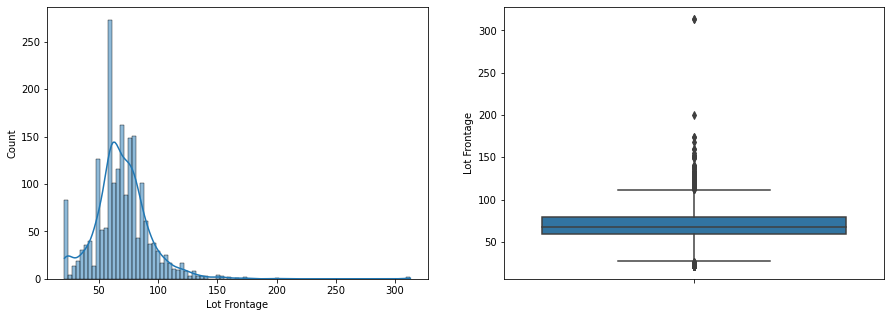

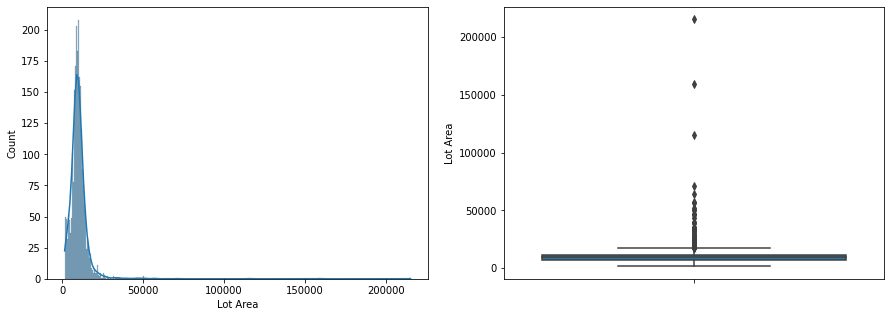

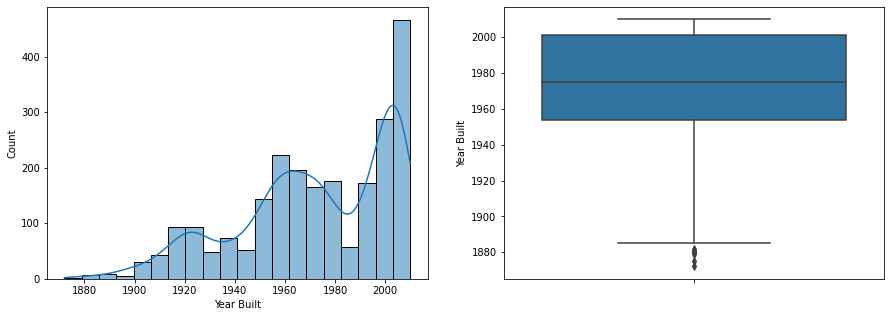

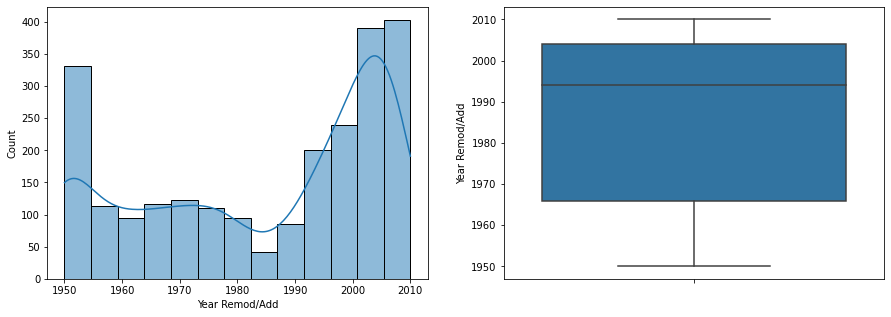

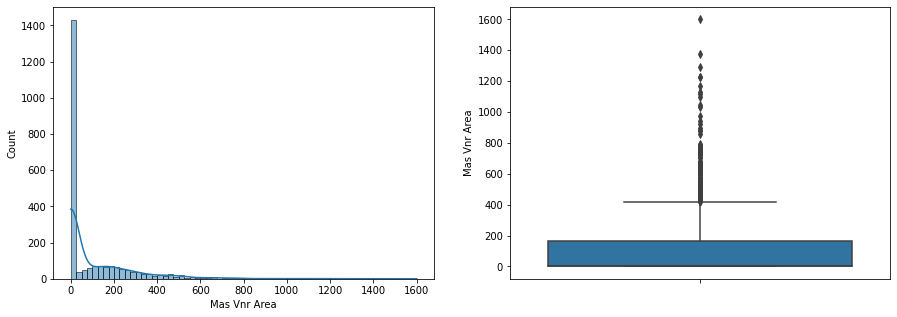

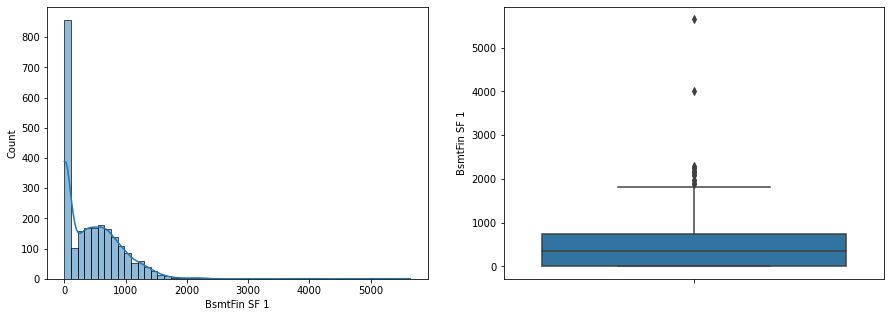

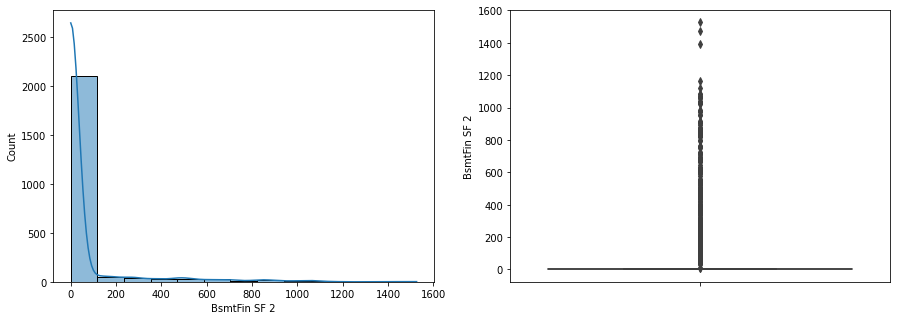

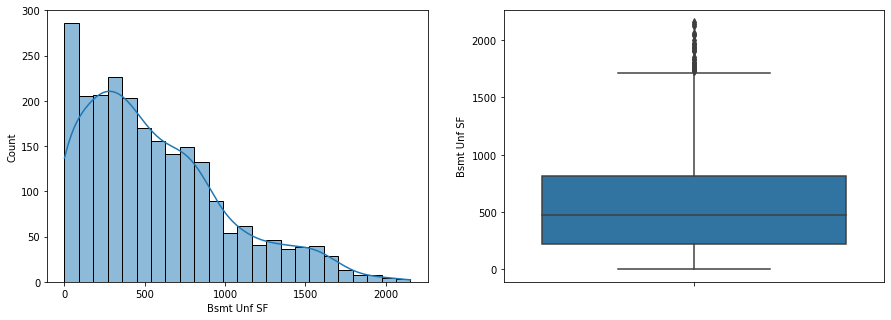

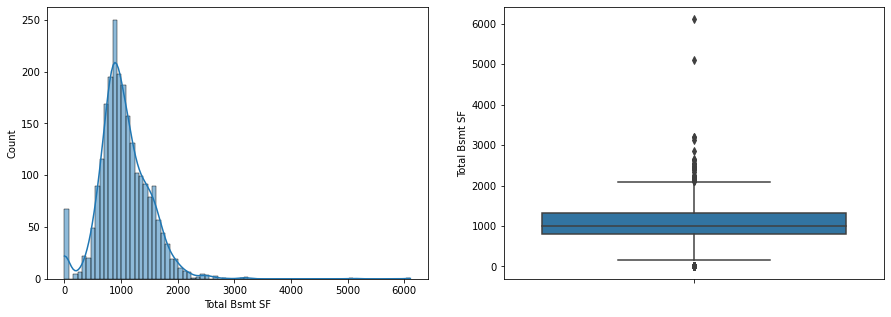

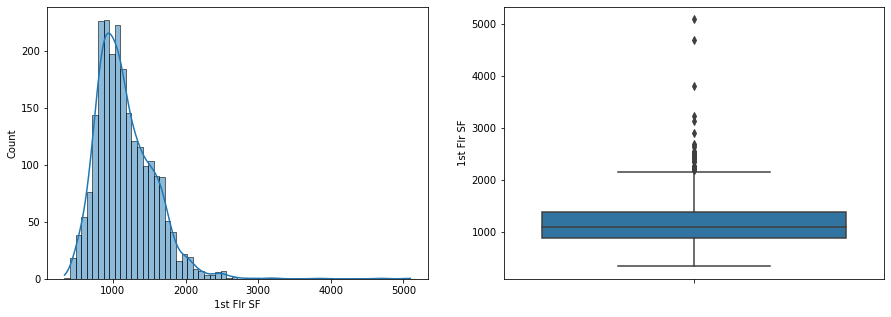

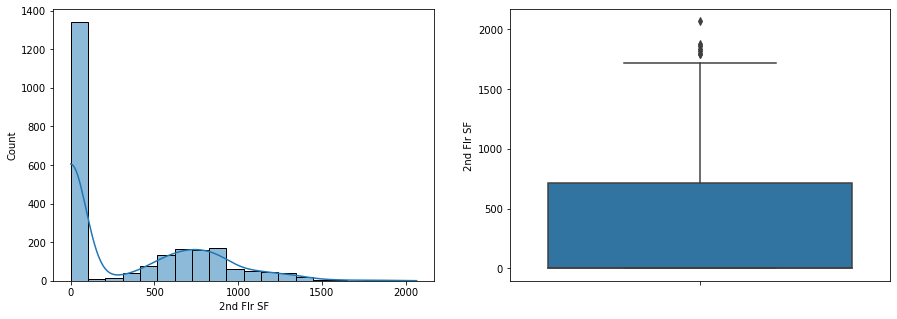

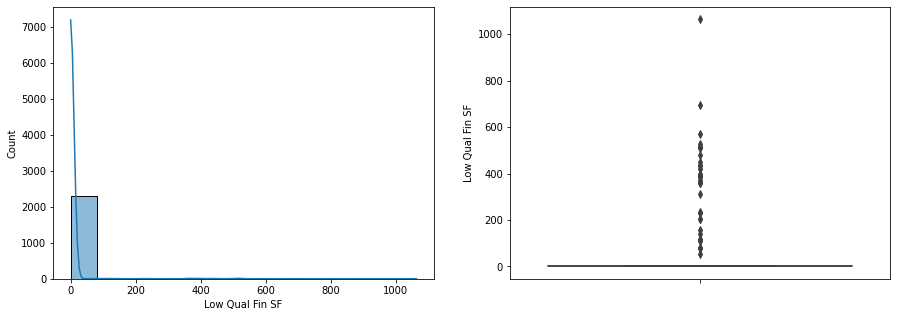

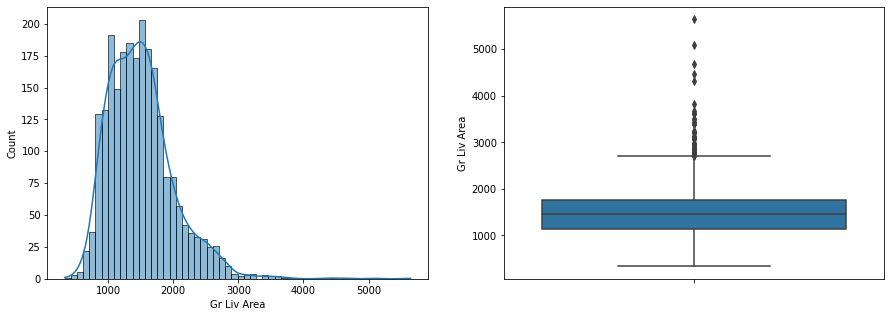

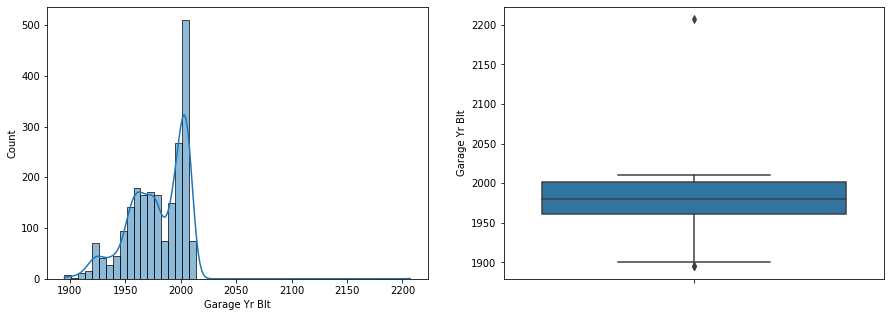

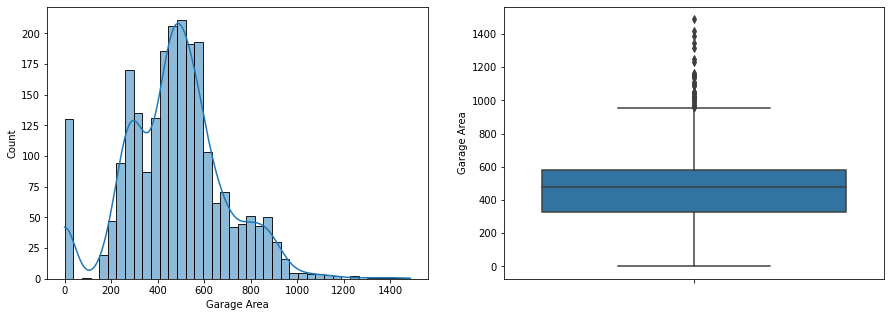

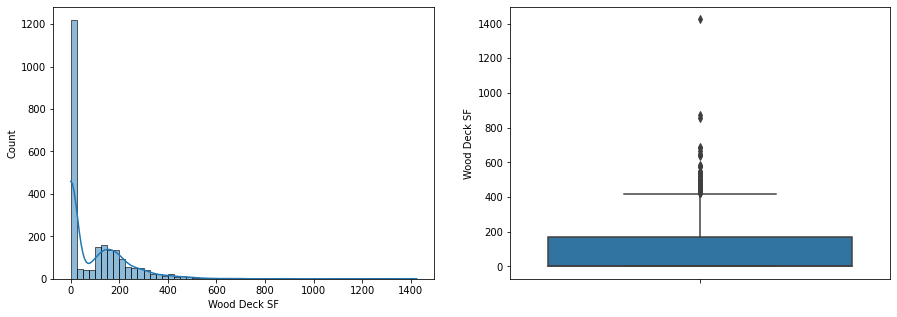

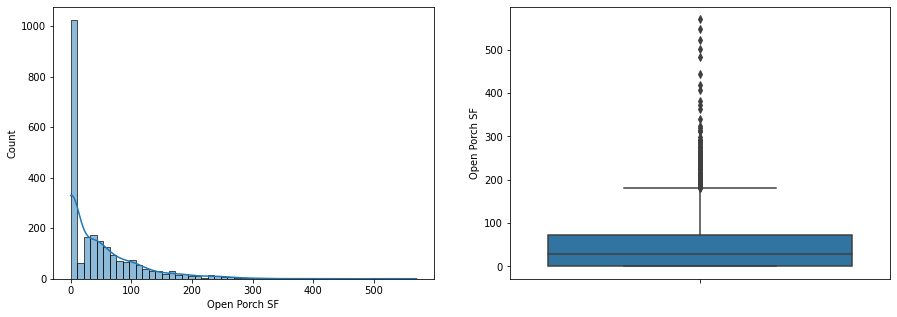

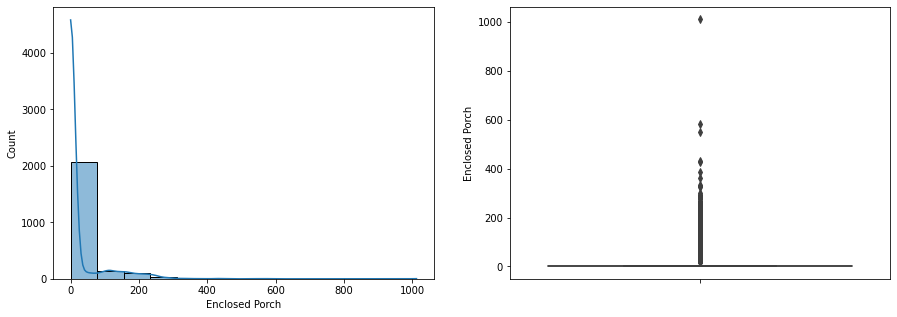

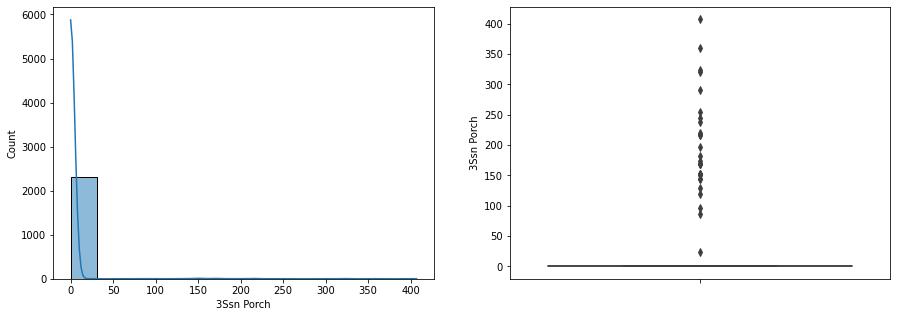

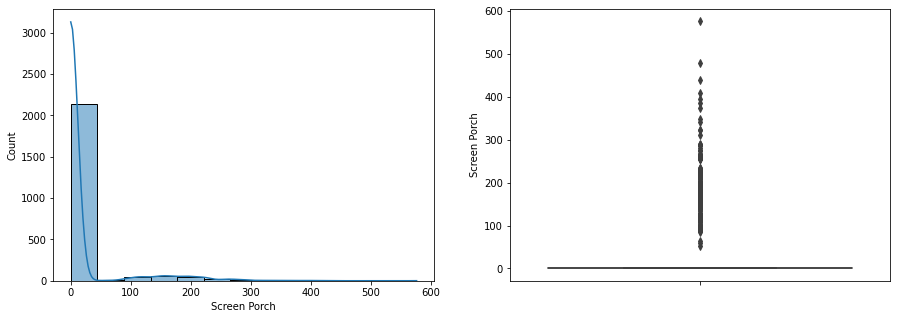

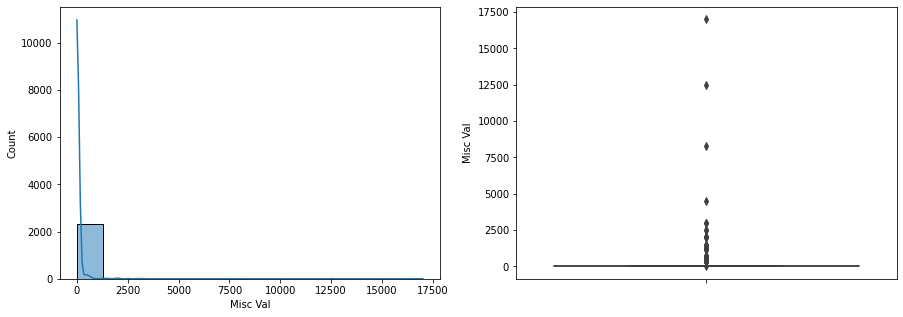

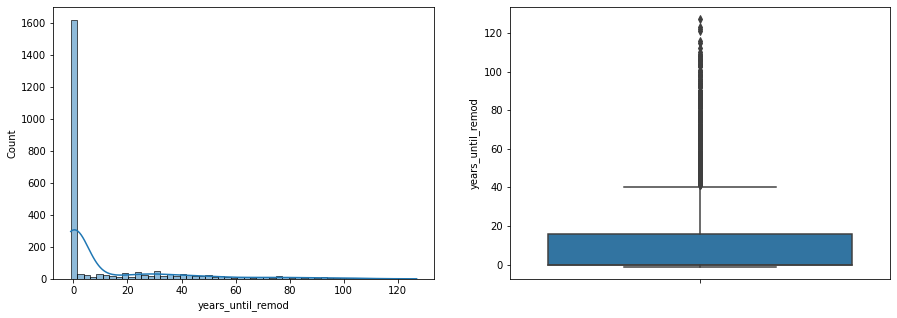

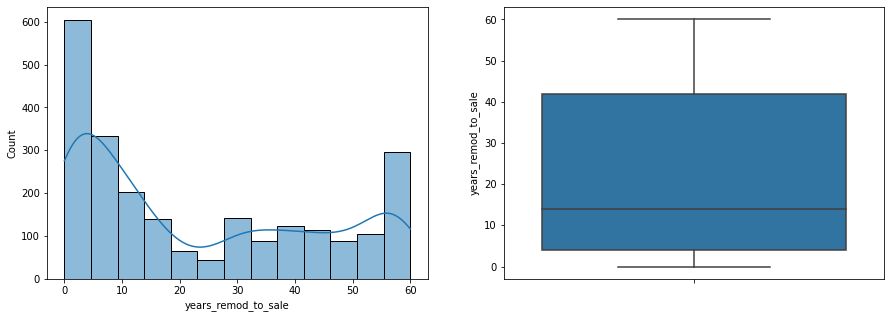

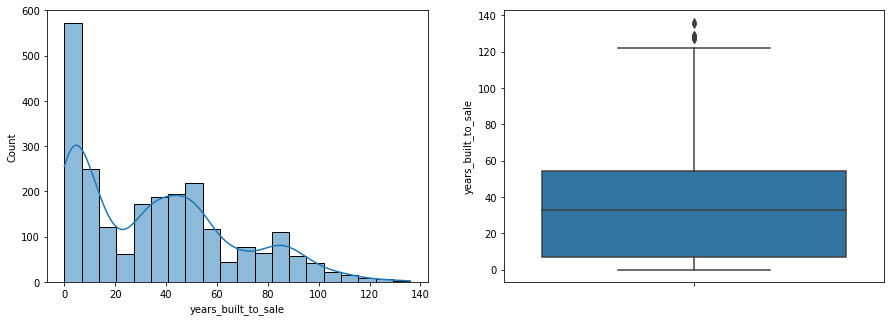

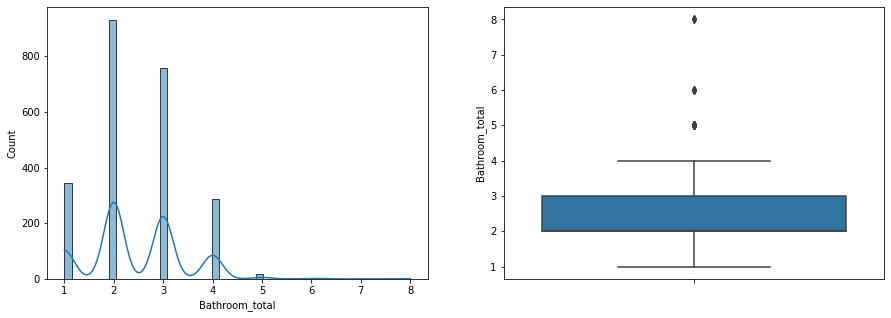

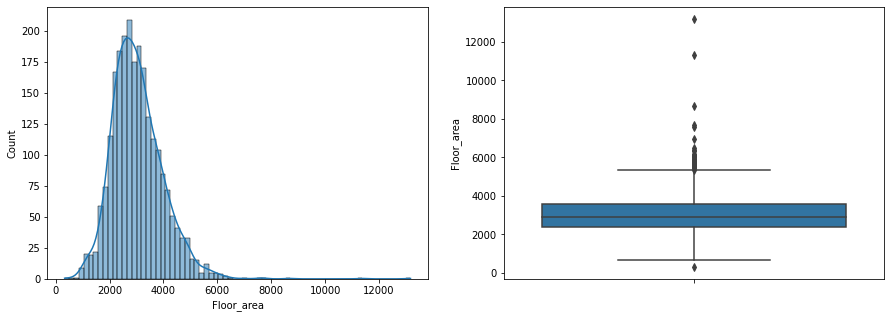

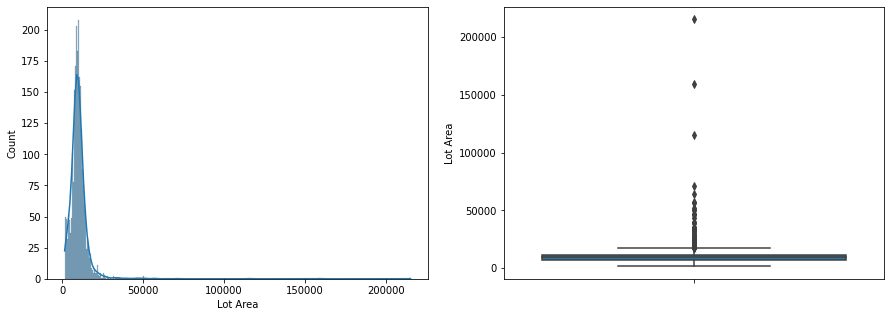

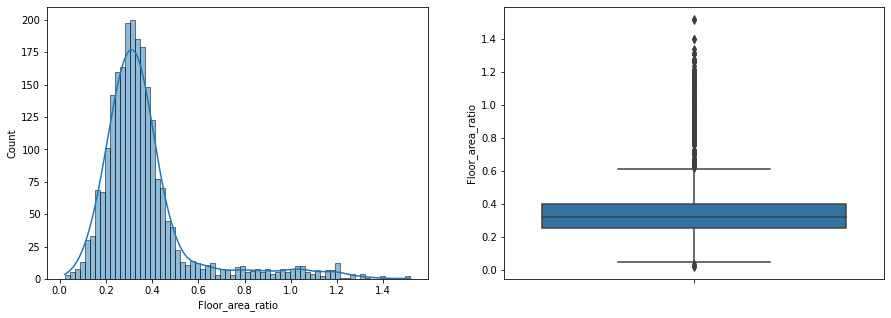

In [20]:
# let's make boxplots to visualise outliers in the continuous variables 
# and histograms to get an idea of the distribution

for var in continuous:
    fig,ax=plt.subplots(1,2,figsize=(15,5))
    sn.histplot(train_valid[var].dropna(), kde=True, ax=ax[0])
    sn.boxplot(y=train_valid[var], ax=ax[1])
    plt.show()

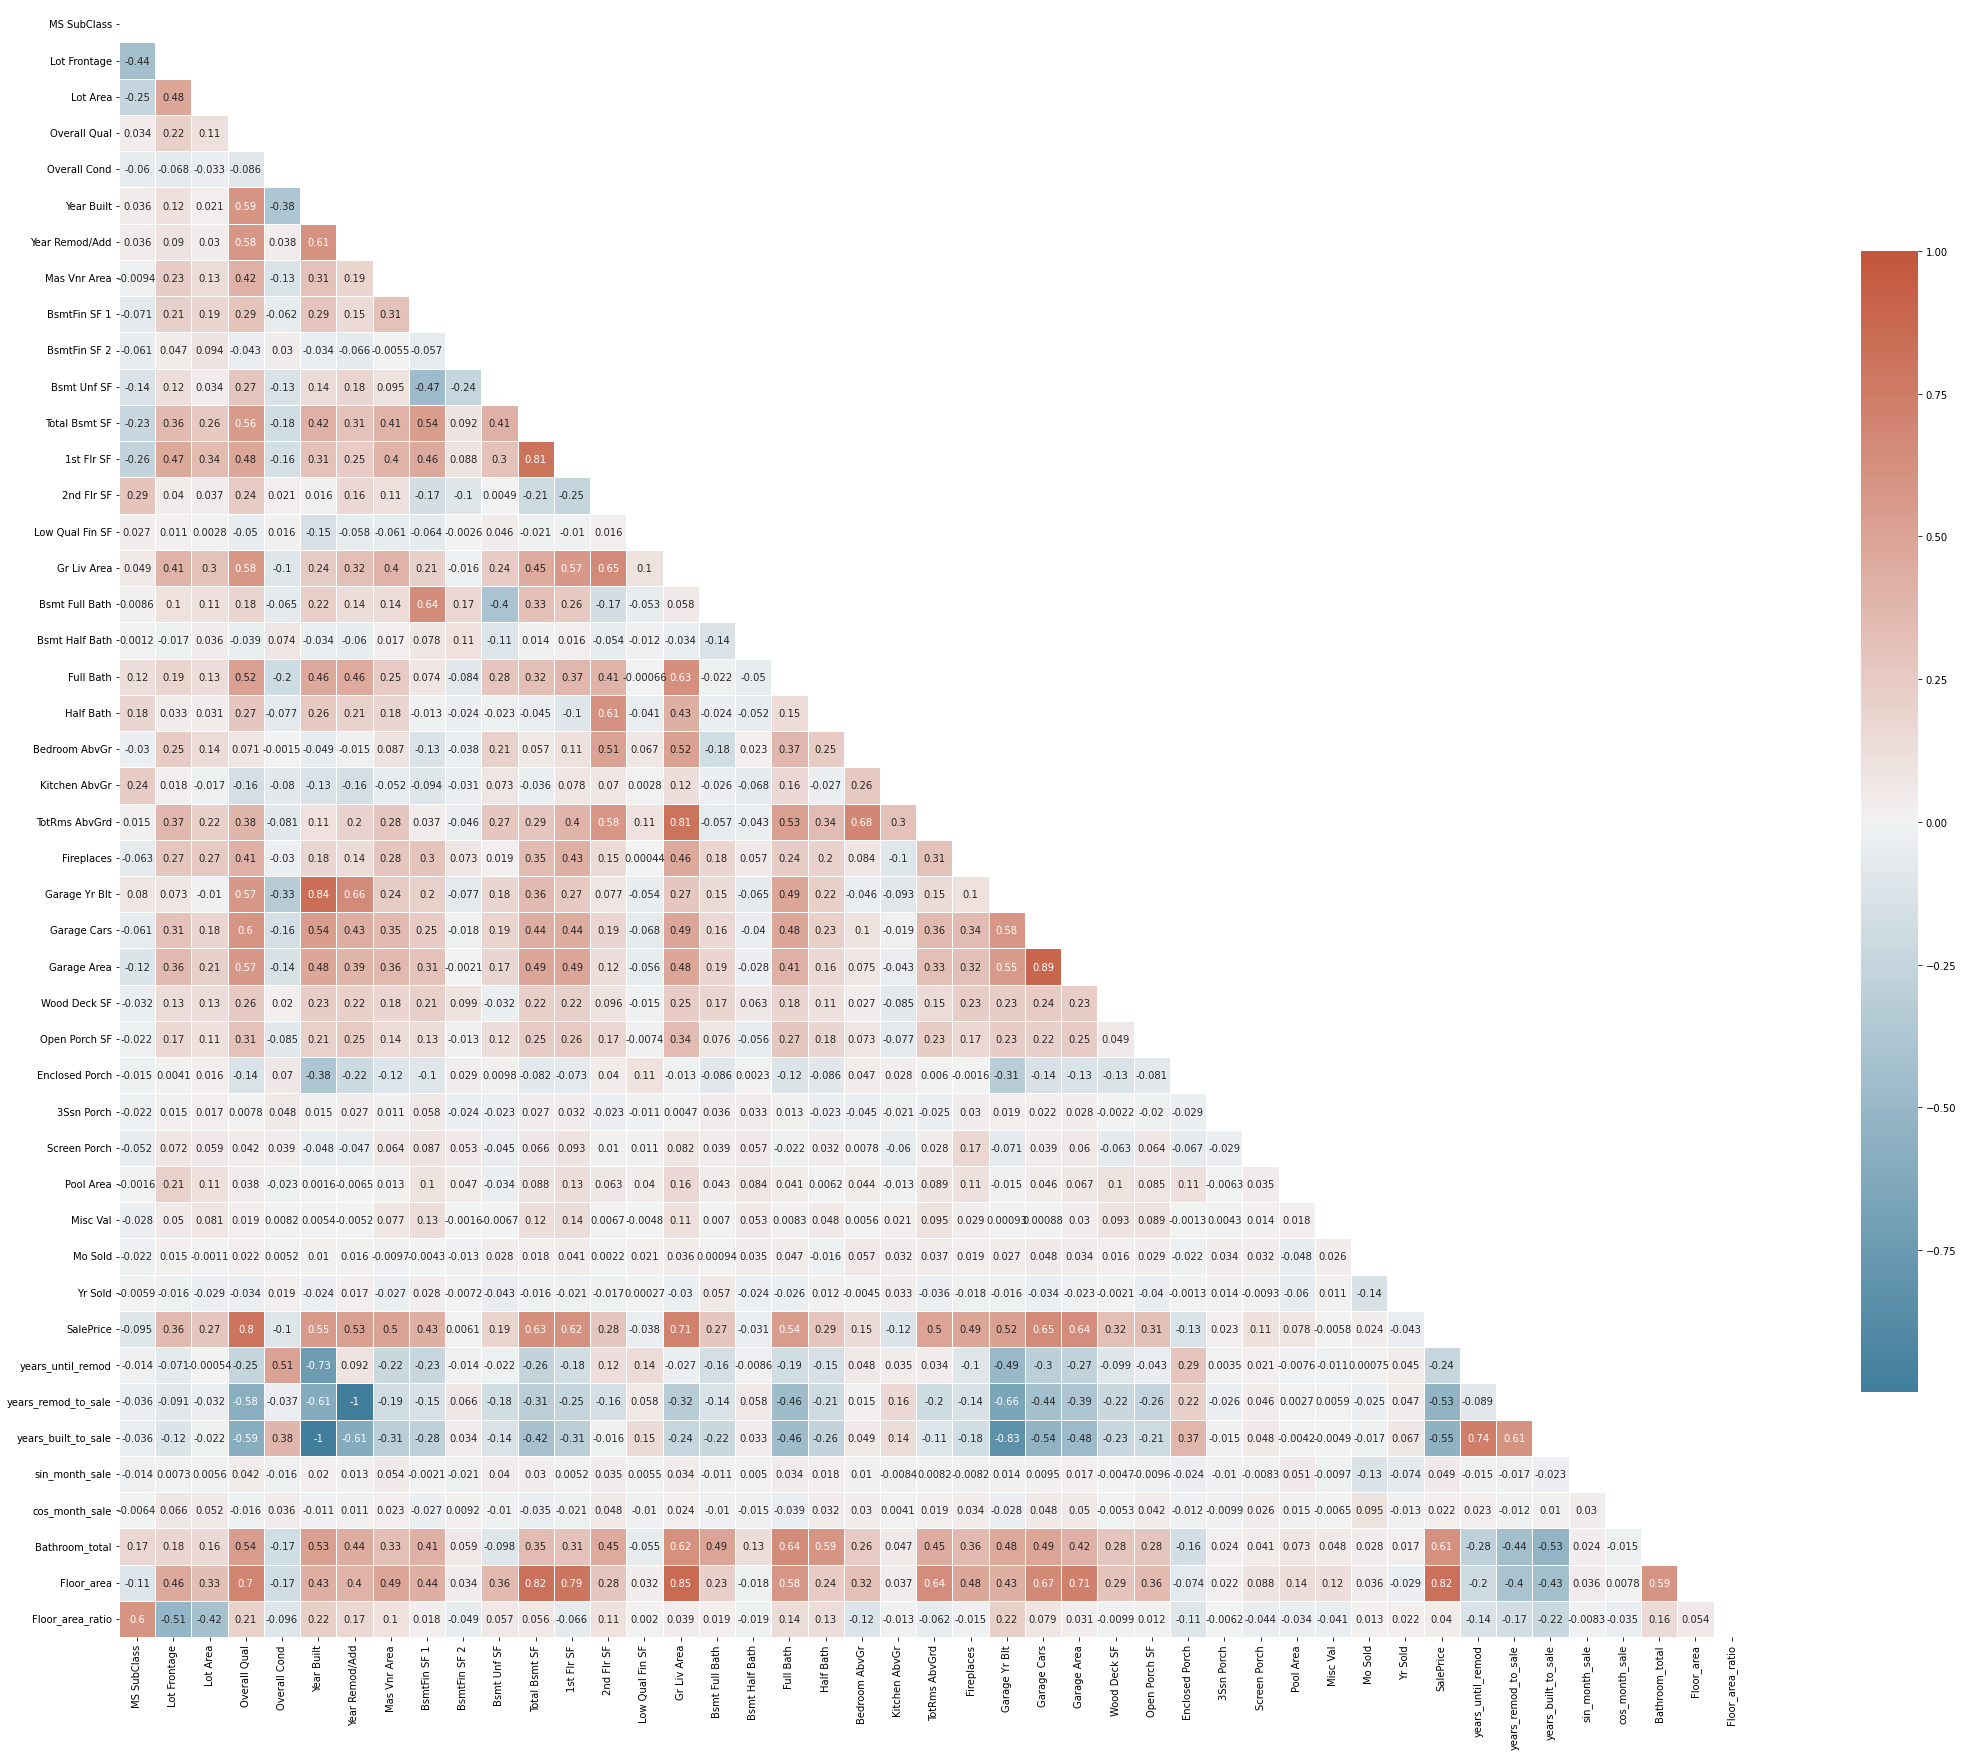

In [21]:
f, ax = plt.subplots(figsize=(40, 30))
mat = train_valid.corr('pearson')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sn.diverging_palette(230, 20, as_cmap=True)
sn.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})
plt.show()

## Linear Regression

In [22]:
def select_features(data):

    return ["Gr Liv Area","SalePrice"]

In [23]:
def train_and_test(data, target):
    train = data[:1460]
    test = data[1460:]
    features = select_features(train)
    features.remove(target)
    reg = LinearRegression()
    reg.fit(train[features], train[target])
    predictions=reg.predict(test[features])
    rmse=np.sqrt(mean_squared_error(predictions,test[target]))
    return rmse

In [24]:
#TEST functions
print(train_and_test(ames_data_transformed, "SalePrice"))

57088.25161263909


. Update transform_features() so that any column from the data frame with more than 25% (or another cutoff value) missing values is dropped. You also need to remove any columns that leak information about the sale (e.g. like the year the sale happened). In general, the goal of this function is to:

    remove features that we don't want to use in the model, just based on the number of missing values or data leakage
    transform features into the proper format (numerical to categorical, scaling numerical, filling in missing values, etc)
    create new features by combining other features
The transform_features() function shouldn't modify the train data frame and instead return a new one entirely. 
This way, we can keep using train in the experimentation cells.
Which columns contain less than 5% missing values?

    For numerical columns that meet this criteria, let's fill in the missing values using the most popular value for that column.

What new features can we create, that better capture the information in some of the features?

    An example of this would be the years_until_remod feature we created in the last lesson.

Which columns need to be dropped for other reasons?

    Which columns aren't useful for machine learning?
    Which columns leak data about the final sale?


# RESEARCH 


The major ideas/logic behind them are:

    Reduce the number of categorical variables whenever possible/appropriate, as each categorical variable will have to be converted into multiple dummy variables for regular multiple linear regression model (a.k.a. ordinary least square (OLS) model) and regularized linear regression models, e.g. Ridge, Lasso, and ElasticNet, which would greatly increase the total number of variables and become very inefficient on prediction.
    Add new promising feature variables based on domain knowledge.
    Remove trivial variables of very low prediction value.
    Adjust variables properly as needed to make sure their values or types are well fit for the purpose of regression, i.e. help to accurately predicting the value of the target variable.

Try more preprocessing choices as BoxCox transformation, PCA, etc. For PCA, we may use the cross-correlation result among all the numerical variables, as shown earlier, to find highly correlated groups of variables, and only PCA on them and see.
Outlier check and removal
Clustering analysis to generate new useful categorical features
Feature selection: try other advanced algorithms e.g. Genetic algorithm, and simulated annealing, from R Caret package.


In [25]:
ames_data_transformed["Yr Sold"].value_counts()

2007.0    694
2009.0    648
2006.0    625
2008.0    622
2010.0    341
Name: Yr Sold, dtype: int64

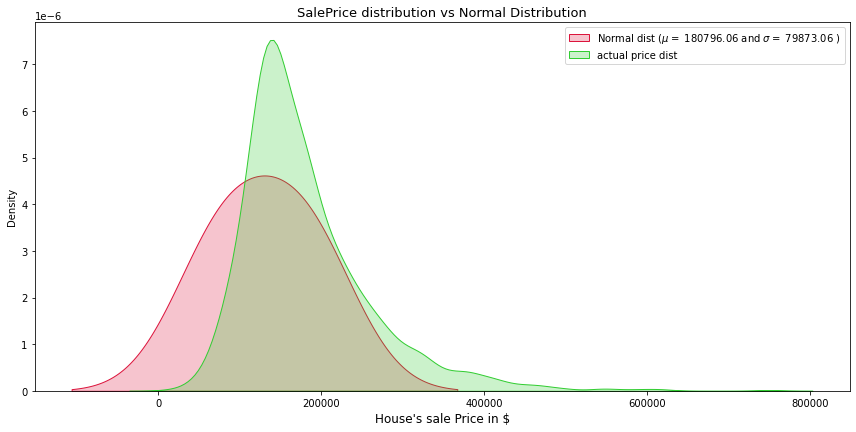

In [26]:
(mu, sigma) = stats.norm.fit(ames_data_transformed['SalePrice'])
fig, ax = plt.subplots(figsize=(12, 6))
sn.kdeplot(data=stats.norm.fit(ames_data_transformed['SalePrice']),
            color='crimson', fill=True, ax=ax)
sn.kdeplot(data=ames_data_transformed["SalePrice"],
            color='limegreen',  fill=True, ax=ax)
plt.tight_layout()
plt.title('SalePrice distribution vs Normal Distribution', fontsize = 13)
plt.xlabel("House's sale Price in $", fontsize = 12)
plt.legend(['Normal dist ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma),'actual price dist'],loc='best')
plt.show()

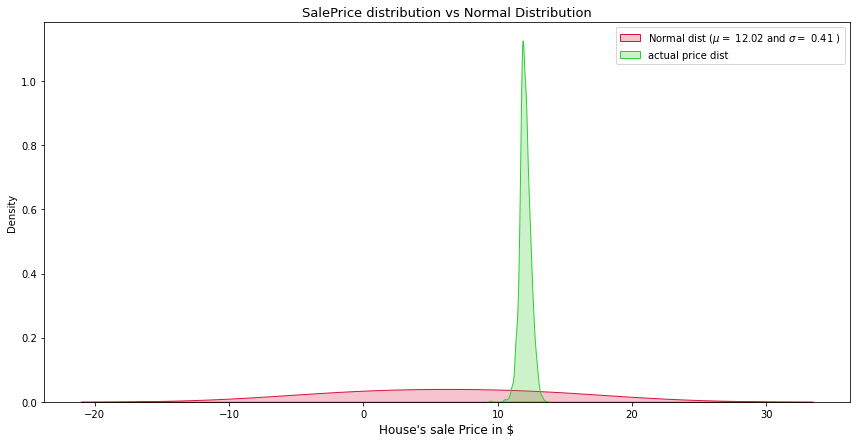

In [27]:
kocionglak = np.log(ames_data_transformed["SalePrice"])
(mu, sigma) = stats.norm.fit(kocionglak)
fig, ax = plt.subplots(figsize=(12, 6))
sn.kdeplot(data=stats.norm.fit(kocionglak),
            color='crimson', fill=True, ax=ax)
sn.kdeplot(data=kocionglak,
            color='limegreen',  fill=True, ax=ax)
plt.tight_layout()
plt.title('SalePrice distribution vs Normal Distribution', fontsize = 13)
plt.xlabel("House's sale Price in $", fontsize = 12)
plt.legend(['Normal dist ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma),'actual price dist'],loc='best')
plt.show()


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


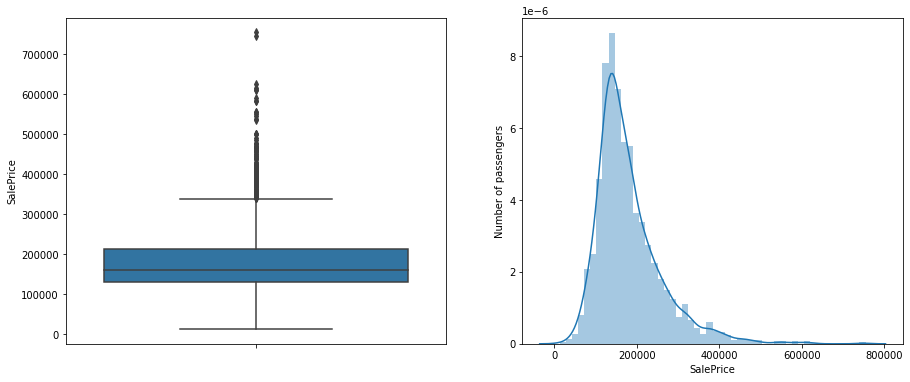

In [28]:
var = 'SalePrice'
y_train = ames_data_transformed["SalePrice"]

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = sn.boxplot(y=y_train)
fig.set_title('')
fig.set_ylabel(var)

plt.subplot(1, 2, 2)
fig = sn.distplot(y_train)#.hist(bins=20)
fig.set_ylabel('Number of passengers')
fig.set_xlabel(var)

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


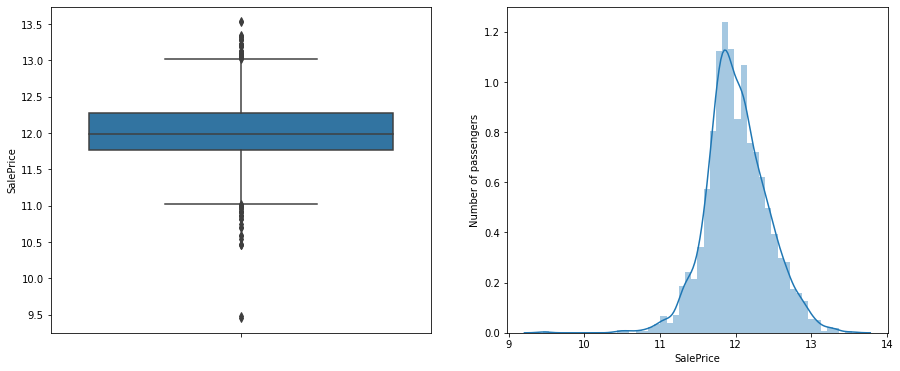

In [29]:
var = 'SalePrice'
y_train = np.log(ames_data_transformed["SalePrice"]) 

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = sn.boxplot(y=y_train)
fig.set_title('')
fig.set_ylabel(var)

plt.subplot(1, 2, 2)
fig = sn.distplot(y_train)#.hist(bins=20)
fig.set_ylabel('Number of passengers')
fig.set_xlabel(var)

plt.show()

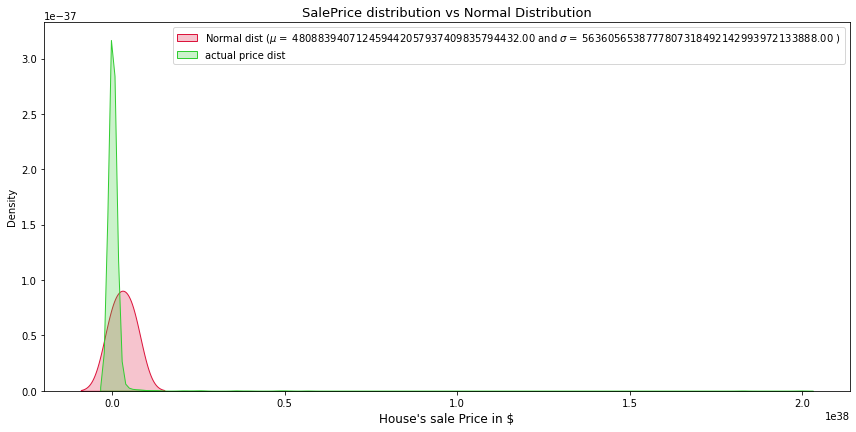

In [30]:
kocionglak2 = stats.boxcox(x = ames_data["SalePrice"].astype(float)+1, lmbda = 6.656) 
(mu, sigma) = stats.norm.fit(kocionglak2)
fig, ax = plt.subplots(figsize=(12, 6))
sn.kdeplot(data=stats.norm.fit(kocionglak2),
            color='crimson', fill=True, ax=ax)
sn.kdeplot(data=kocionglak2,
            color='limegreen',  fill=True, ax=ax)
plt.tight_layout()
plt.title('SalePrice distribution vs Normal Distribution', fontsize = 13)
plt.xlabel("House's sale Price in $", fontsize = 12)
plt.legend(['Normal dist ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma),'actual price dist'],loc='best')
plt.show()


In [31]:
stat, p = stats.shapiro(ames_data_transformed["SalePrice"])
print('stat=%.3f, p=%.3f\n' % (stat,p))
if p > 0.05:
    print('Probably Gausiann.')
else:
    print('Probably not Gausiann.')

stat=0.876, p=0.000

Probably not Gausiann.


In [32]:
kocionglak = ames_data_transformed["SalePrice"].apply(lambda x: math.log(float(x)))
stat, p = stats.shapiro(kocionglak)
print('stat=%.3f, p=%.3f\n' % (stat,p))
if p > 0.05:
    print('Probably Gausiann.')
else:
    print('Probably not Gausiann.')

stat=0.986, p=0.000

Probably not Gausiann.


In [33]:
kocionglak2 = stats.boxcox(x = ames_data["SalePrice"].astype(float)+1 , lmbda = 6.656) 
stat, p = stats.shapiro(kocionglak2)
print('stat=%.3f, p=%.3f\n' % (stat,p))
if p > 0.05:
    print('Probably Gausiann.')
else:
    print('Probably not Gausiann.')

stat=0.051, p=0.000

Probably not Gausiann.


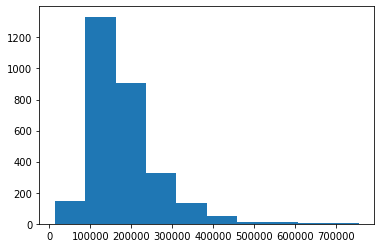

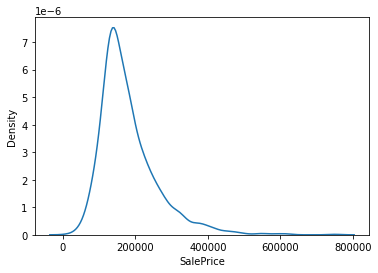

In [34]:
plt.hist(ames_data_transformed["SalePrice"])
plt.show()
sn.kdeplot(ames_data_transformed["SalePrice"])
plt.show()

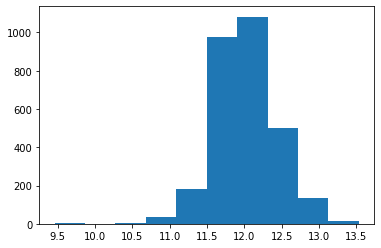

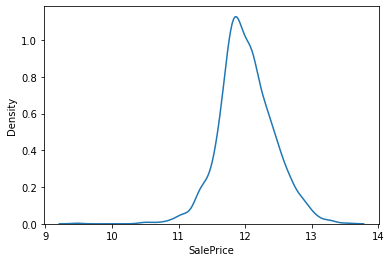

In [35]:
plt.hist(kocionglak)
plt.show()
sn.kdeplot(kocionglak)
plt.show()

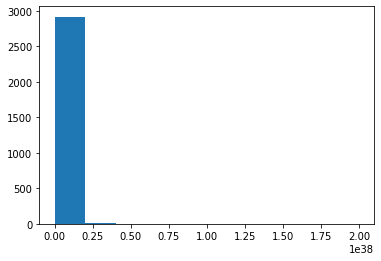

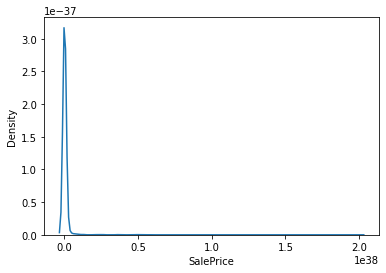

In [36]:
plt.hist(kocionglak2)
plt.show()
sn.kdeplot(kocionglak2)
plt.show()